In [31]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

from numba import njit, prange
from timeit import default_timer as timer

In [32]:
dt = .001
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 1.5
bifurcate_time = 0
sgm = 5
threshold = 70
R_initial = 32
eta = 0

In [33]:
speed_alpha = 33.842539
speed_beta = 1.821676
speed_sigma = 35.723187
speed_S = 2368.22093
speed_tauR = 0.33628
speed_tauG = 0.001002
speed_tauD = 0.226118
speed_params = [speed_alpha, speed_beta, speed_sigma, speed_S, speed_tauR, speed_tauG, speed_tauD]

In [34]:
accuracy_alpha = 34.695025
accuracy_beta = 0.978248
accuracy_sigma = 16.577909
accuracy_S = 350.064641
accuracy_tauR = 0.008438
accuracy_tauG = 0.112152
accuracy_tauD = 0.155874
accuracy_params = [accuracy_alpha, accuracy_beta, accuracy_sigma, accuracy_S, accuracy_tauR, accuracy_tauG, accuracy_tauD]

In [20]:
def get_dynamic_arr(coh, a, b, sgm, S, tauR, tauG, tauD):
    alpha = a
    beta = 0
    V1, V2 = S, S

    R1_arr = np.zeros(int(dur / dt))
    R2_arr = np.zeros(int(dur / dt))
    # R1_arr[0] = ((alpha - 1) + np.sqrt((1 - alpha) ** 2 + 4 * S * (w11 + w12 - beta))) / (2 * (w11 + w12 - beta))
    # R2_arr[0] = ((alpha - 1) + np.sqrt((1 - alpha) ** 2 + 4 * S * (w22 + w21 - beta))) / (2 * (w22 + w21 - beta))
    R1_arr[0], R2_arr[0] = 32, 32

    G1_arr = np.zeros(int(dur / dt))
    G2_arr = np.zeros(int(dur / dt))
    G1_arr[0], G2_arr[0] = (w11 + w12 - beta) * R1_arr[0], (w22 + w21 - beta) * R2_arr[0]

    D1_arr = np.zeros(int(dur / dt))
    D2_arr = np.zeros(int(dur / dt))
    D1_arr[0], D2_arr[0] = beta * R1_arr[0], beta * R2_arr[0]

    noise_R1 = np.zeros(int(dur / dt))
    noise_R2 = np.zeros(int(dur / dt))
    noise_G1 = np.zeros(int(dur / dt))
    noise_G2 = np.zeros(int(dur / dt))
    noise_D1 = np.zeros(int(dur / dt))
    noise_D2 = np.zeros(int(dur / dt))

    for ti in range(1, int(dur / dt)):

        if ti >= bifurcate_time / dt:
            beta = b

        if ti >= bifurcate_time / dt and ti % 5 == 0:
            V1 = S * (1 + coh) + np.random.randn() * eta
            V2 = S * (1 - coh) + np.random.randn() * eta

        d_noiseR1 = (-noise_R1[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
        d_noiseR2 = (-noise_R2[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
        d_noiseG1 = (-noise_G1[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
        d_noiseG2 = (-noise_G2[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
        d_noiseD1 = (-noise_D1[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt
        d_noiseD2 = (-noise_D2[ti - 1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau * dt

        d_R1 = (-R1_arr[ti - 1] + (alpha * R1_arr[ti - 1] + V1) / (1 + G1_arr[ti - 1])) * dt / tauR
        d_R2 = (-R2_arr[ti - 1] + (alpha * R2_arr[ti - 1] + V2) / (1 + G2_arr[ti - 1])) * dt / tauR
        d_G1 = (-G1_arr[ti - 1] + w11 * R1_arr[ti - 1] + w12 * R2_arr[ti - 1] - D1_arr[ti - 1]) * dt / tauG
        d_G2 = (-G2_arr[ti - 1] + w21 * R1_arr[ti - 1] + w22 * R2_arr[ti - 1] - D2_arr[ti - 1]) * dt / tauG
        d_D1 = (-D1_arr[ti - 1] + beta * R1_arr[ti - 1]) * dt / tauD
        d_D2 = (-D2_arr[ti - 1] + beta * R2_arr[ti - 1]) * dt / tauD

        noise_R1[ti] = noise_R1[ti - 1] + d_noiseR1
        noise_R2[ti] = noise_R2[ti - 1] + d_noiseR2
        noise_G1[ti] = noise_G1[ti - 1] + d_noiseG1
        noise_G2[ti] = noise_G2[ti - 1] + d_noiseG2
        noise_D1[ti] = noise_D1[ti - 1] + d_noiseD1
        noise_D2[ti] = noise_D2[ti - 1] + d_noiseD2

        R1_arr[ti] = max(R1_arr[ti - 1] + d_R1 + noise_R1[ti], 0)
        R2_arr[ti] = max(R2_arr[ti - 1] + d_R2 + noise_R2[ti], 0)
        G1_arr[ti] = max(G1_arr[ti - 1] + d_G1 + noise_G1[ti], 0)
        G2_arr[ti] = max(G2_arr[ti - 1] + d_G2 + noise_G2[ti], 0)
        D1_arr[ti] = max(D1_arr[ti - 1] + d_D1 + noise_D1[ti], 0)
        D2_arr[ti] = max(D2_arr[ti - 1] + d_D2 + noise_D2[ti], 0)

        if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
            print("R1")
            break
        elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
            print("R2")
            break
        elif ti == dur/dt-1:
            print("NAN")

    return R1_arr, R2_arr, G1_arr, G2_arr, D1_arr, D2_arr

In [21]:
def draw_dynamic(c, a, b, sgm, S, tauR, tauG, tauD, color):
    R1_arr, R2_arr, G1_arr, G2_arr, D1_arr, D2_arr = get_dynamic_arr(c, a, b, sgm, S, tauR, tauG, tauD)

    plt.plot(R1_arr, color=color, linewidth=1.5, label='R1')
    plt.plot(R2_arr, color=color, linestyle='--', linewidth=1, label='R2')

    plt.xlabel("RT (ms)")
    plt.ylabel("Activity (Hz)")
    plt.ylim(top=85, bottom=0)
    plt.xlim(left=0)
    plt.title("Single Trial Dynamic")

    plt.tight_layout()

R1


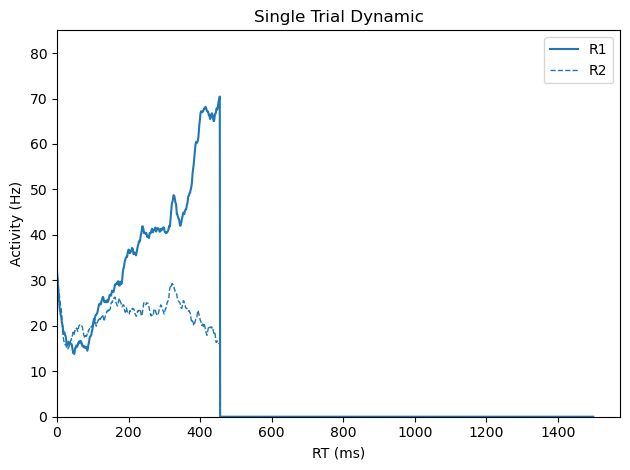

In [50]:
draw_dynamic(0, *accuracy_params, 'C0')
plt.legend()

In [46]:
@njit(parallel=True, fastmath=True)
def ave_choice(coh, a, b, sgm, S, tauR, tauG, tauD):

    alpha = a

    nan_num = 0
    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)

    for i in prange(10240):

        beta = 0
        V1, V2 = S, S

        R1_arr = np.zeros(int(dur/dt))
        R2_arr = np.zeros(int(dur/dt))
        R1_arr[0], R2_arr[0] = R_initial, R_initial
        # R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
        # R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

        G1_arr = np.zeros(int(dur/dt))
        G2_arr = np.zeros(int(dur/dt))
        G1_arr[0], G2_arr[0] = (w11+w12-beta)*R1_arr[0], (w22+w21-beta)*R2_arr[0]

        D1_arr = np.zeros(int(dur/dt))
        D2_arr = np.zeros(int(dur/dt))
        D1_arr[0], D2_arr[0] = beta*R1_arr[0], beta*R2_arr[0]

        noise_R1 = np.zeros(int(dur/dt))
        noise_R2 = np.zeros(int(dur/dt))
        noise_G1 = np.zeros(int(dur/dt))
        noise_G2 = np.zeros(int(dur/dt))
        noise_D1 = np.zeros(int(dur/dt))
        noise_D2 = np.zeros(int(dur/dt))

        for ti in range(1, int(dur/dt)):

            if ti == bifurcate_time/dt:
                beta = b

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                V1 = S*(1+coh) + np.random.randn() * eta
                V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tauR
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tauR
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tauG
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tauG
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tauD
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tauD

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
                choice[i] = 1
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN
                nan_num += 1
                return R1_arr, R2_arr


    reaction_time *= dt
    return np.zeros(10240), np.zeros(10240)


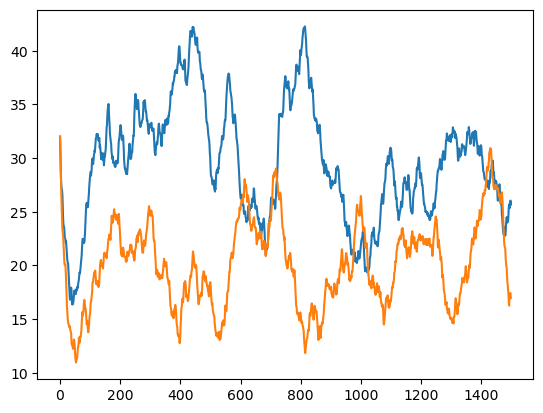

In [47]:
R1, R2 = ave_choice(.128, *accuracy_params)
plt.plot(R1)
plt.plot(R2)
